In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime

In [0]:
# helper 함수
def weight_variables(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# convolution layer
def conv_layer(input_, shape):
  W = weight_variables(shape)
  b = bias_variable([shape[3]])
  return tf.nn.relu(conv2d(input_, W) + b)

# fully-connected layer
def full_layer(input_, size):
  in_size = int(input_.get_shape()[1])
  W = weight_variables([in_size, size])
  b = bias_variable([size])
  return tf.matmul(input_, W) + b

In [3]:
# cifar10 데이터 불러오기
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
def cifar10_load():

  (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

  # Train - Image
  train_x = train_x.astype('float32') / 255

  # Train - Label(OneHot)
  train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)

  # Test - Image
  test_x = test_x.astype('float32') / 255
      
  # Test - Label(OneHot)
  test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)
      
  return (train_x, train_y), (test_x, test_y)

In [5]:
STEPS = 5000
MINIBATCH_SIZE = 50


(train_x, train_y), (test_x, test_y) = cifar10_load()

dataset = tf.data.Dataset.from_tensor_slices(({"image": train_x}, train_y))

dataset = dataset.shuffle(100000).repeat().batch(MINIBATCH_SIZE)

iterator = dataset.make_one_shot_iterator()

next_batch = iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [6]:
print("Number of train images: {}".format(len(train_x)))
print("Number of train labels: {}".format(len(train_y)))
print("Number of test images: {}".format(len(test_x)))
print("Number of test labels: {}".format(len(test_y)))

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test labels: 10000


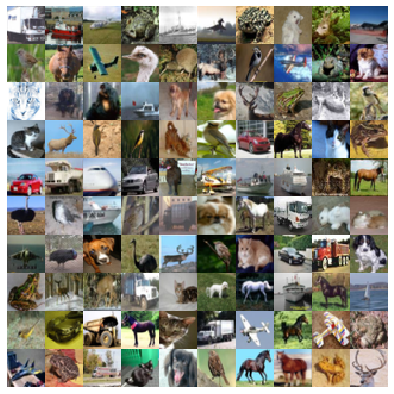

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

matplotlib.rc('font', family='NanumGothic')


def display_cifar(images, size):
  
  n = len(images)
  plt.figure()
  plt.gca().set_axis_off()
  im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for i in range(size)])
  plt.imshow(im)
  plt.show()
      
figsize(15, 7)
display_cifar(train_x, 10)

In [0]:
(train_x, train_y), (test_x, test_y) = cifar10_load()

dataset = tf.data.Dataset.from_tensor_slices(({"image": train_x}, train_y))
dataset = dataset.shuffle(100000).repeat().batch(MINIBATCH_SIZE)
iterator = dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

In [9]:
# CNN 모델링
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 8*8*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full_1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full_1_drop, 10)

# 손실함수
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  start_time = datetime.now()

  # 학습
  for step in range(STEPS+1):
    batch_xs, batch_ys = sess.run(next_batch)
    _, loss_val = sess.run([train_step, loss], feed_dict={x: batch_xs['image'], y_: batch_ys, keep_prob: 0.5})
          
    if (step) % 100 == 0:
      print('step = ', step, ', loss_val = ', loss_val)
              
  X = test_x.reshape([10, 1000, 32, 32, 3])
  Y = test_y.reshape([10, 1000, 10])

  end_time = datetime.now()

  print('Elapsed Time => ', end_time-start_time)

  test_accuracy = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i], keep_prob: 1.0}) for i in range(10)])
  print("test accuracy: {}".format(test_accuracy))

step =  0 , loss_val =  17.675257
step =  100 , loss_val =  2.098295
step =  200 , loss_val =  1.7979531
step =  300 , loss_val =  1.5817893
step =  400 , loss_val =  1.4094692
step =  500 , loss_val =  1.6545678
step =  600 , loss_val =  1.3411479
step =  700 , loss_val =  1.4420934
step =  800 , loss_val =  1.376824
step =  900 , loss_val =  1.3381064
step =  1000 , loss_val =  1.2576976
step =  1100 , loss_val =  1.157848
step =  1200 , loss_val =  0.98936445
step =  1300 , loss_val =  1.254199
step =  1400 , loss_val =  1.1612035
step =  1500 , loss_val =  1.0994765
step =  1600 , loss_val =  1.2149234
step =  1700 , loss_val =  0.95337546
step =  1800 , loss_val =  0.8888628
step =  1900 , loss_val =  0.92144364
step =  2000 , loss_val =  1.0034655
step =  2100 , loss_val =  0.79824203
step =  2200 , loss_val =  1.0466378
step =  2300 , loss_val =  0.7467296
step =  2400 , loss_val =  0.66478103
step =  2500 , loss_val =  0.7650311
step =  2600 , loss_val =  1.0345945
step =  2700